<a href="https://colab.research.google.com/github/Shrey-2303/Point-cloud-recontruction-and-PointNet-classification/blob/main/Copy_of_Neural_Fields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Neural Fields to Represent Image

In this colab, you are going to do a small coding exercise where you will train a neural network to represent an image.

In [ ]:
!pip install imageio-ffmpeg
!pip install lovely-tensors

# TODO isntall what you need

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os, imageio
import numpy as np
import torch
lt.monkey_patch()

# TODO import what you need

# Data

Our data will be pairs of $(x, y)$, where $x\in \mathbb{R}^2$ parameterize the pixel location, and $y\in \mathbb{R}^3$ is the RGB.

In this section, we will write a pytorch dataloader to produce these pairs.

<ipython-input-4-134d0b79aeca>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3]


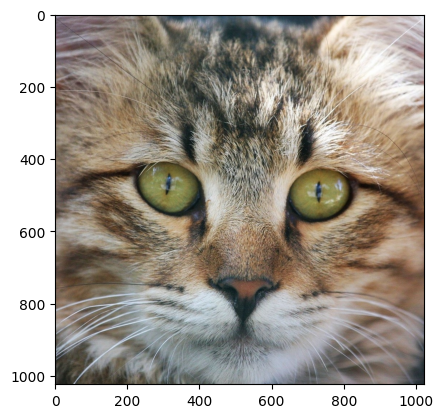

In [ ]:
# Download image, take a square crop from the center
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
plt.imshow(img)
plt.show()

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img):
        self.img = img # shape=(res, res, 3)
        # TODO: create positions
        self.sh = np.shape(self.img)
        self.height = self.sh[0]
        print(self.height)
        self.width = self.sh[1]
        print(self.height)
        self.positions = []
        for x in range(self.height):
            for y in range(self.width):
                self.positions.append([x,y])
        self.rgb_data = []
        for x in self.positions: self.rgb_data.append(img[x[0],x[1]])
        # TODO: parameterize the RGB output
        self.X = np.array(self.positions) # TODO: (..., 2)
        self.Y = np.array(self.rgb_data) # TODO: (..., 3)

    def __len__(self):
        return self.X.shape[0]
        pass
    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]
        pass
# TODO test your dataset
dataset = CustomImageDataset(img)
print(dataset.X.shape)
print(dataset.Y.shape)
#loader = DataLoader(dataset, batch_size=64, shuffle=True)
#xy, rgb = next(iter(loader))
#xy, rgb

1024
1024
(1048576, 2)
(1048576, 3)


# Network Architecture


Tips: you might find it useful to use Fourier positional encoding helpful! Check these papers:
1. https://arxiv.org/abs/2006.09661
2. https://arxiv.org/abs/2006.10739
3. https://arxiv.org/abs/2003.08934



In [ ]:
import torch.nn as nn


def pos_enc(x, *args, **kwargs):
    batch_size, sequence_length, feature_dim = x.size()

    # Create frequency values
    t = torch.arange(sequence_length, dtype=torch.float32).to(x.device)
    frequencies = torch.arange(num_bands, dtype=torch.float32).to(x.device)
    frequencies = max_freq * 2.0**frequencies / sequence_length

    # Compute Fourier encodings
    encodings = torch.einsum("btf,bf->bft", [t, frequencies])
    encodings = encodings.reshape(1, sequence_length, num_bands)
  #raise NotImplemented
    return x + encodings

class Net(nn.Module):

  def __init__(self, inp_dim, out_dim, hid_dims=[128], **kwargs):
    super().__init__()
    self.layers = nn.ModuleList()
    curr_dim = inp_dim
    for dim in hid_dims:
      self.layers.append(nn.Dense(curr_dim, dim))
      curr_dim = dim
    self.nonlin = nn.ReLU()
    self.out = nn.Dense(curr_dim, out_dim)

    # TODO: pass parameters to positional encoding


  def forward(self, x):
    # TODO: pass parameters to positional encoding
    z = pos_enc(x)
    for layer in self.layers:
      z = self.nonlin(layer(z))
    return self.out(z)

In [ ]:
# Test your architecture
net = Net(2, 3, [128, 128])
batch_size = 128
net(torch.ones((batch_size, 2)))


# Training

In [ ]:
# Define metrics
def compute_psnr(gtr, out):
  raise NotImplemented

# Define
def compute_loss(out, y):
  raise NotImplemented

# Preparing training, (e.g. initialize optimizer ...)
opt = None

dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
for iter in range(10000):
  try:
    x, y = next(data_iter)
  except StopIteration:
    # StopIteration is thrown if dataset ends
    # reinitialize data loader
    data_iter = iter(loader)
    x, y = next(data_iter)

  x, y = x.cuda(), y.cuda()
  opt.zero_grad()
  out = net(x)
  loss = compute_loss(out, y)
  loss.backward()
  opt.step()

  # TODO: monitor the training.

# Testing

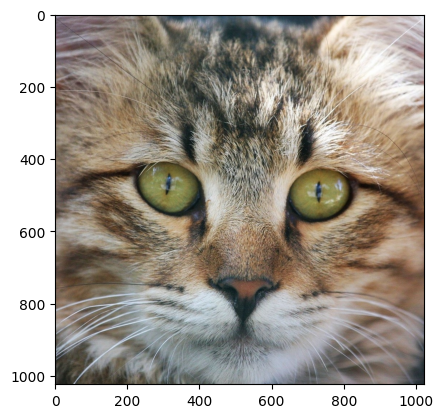

In [ ]:
def create_image(resolution):
  # TODO: make xy coordinate
  x = None
  rgb = net(x).reshape(resolution, resolution, 3)
  return rgb.detach().cpu().numpy()

out_img = create_image(1024)
plt.imshow(out_img)
plt.show()

In [ ]:
out_img = create_image(1024*8)
plt.imshow(out_img)
plt.show()

# Some open questions

- Does the network know the face is symmetry?
- What would you do to enforce the network outputs symmetry signals?